# Model Selection and Evaluation

In this notebook, our goal will be to use the insights garnered from EDA to create a feature-selected and finetuned model that will perform well on generalized, unseen data.

After we pick out our features, based on insights garnered from our many visualizations prior, we will go through our modelling process as per below:

1. Split the data into train, test, and validation.
2. Train as many models as there are hyperparameter combinations on the train set. 
3. Evaluate each of these models on the validation set.
4. Select the model with the best performance on the validation set. 
5. Retrain the model on the combined train + validation sets using 'winning' hyperparameter combination.
6. Estimate generalisation performance on the test set. If the test error is similar to the validation error then we have belief that this model will generalise well to unseen data.

Workflow source:https://github.com/esentri/datascience_blog_resources/blob/master/model_selection.ipynb

# Imports

In [2]:
#usual imports for sklearn modelling 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score

#advanced supervised classification models for wnv virus detection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from xgboost import XGBClassifier

#classification metrics imports 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
from sklearn.metrics import f1_score
from sklearn import metrics

**Please also type in the following command line/terminal installations**:

* `pip install plotly`
* `brew install libomp` 
* `pip install xgboost`

In [3]:
#We will then be importing these libraries: 

from plotly import __version__
import plotly.offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

print(__version__)
#learnt this from 
#https://towardsdatascience.com/interactive-distribution-plots-with-plotly-ea58efc78885

import cufflinks as cf
#we have to make sure this code is run for Jupyter Notebooks otherwise the plots may not happen:

init_notebook_mode(connected=True)

#we have to make sure this code is run otherwise the visualizations won't run offline:
cf.go_offline()

4.8.1


# Data Importing and Final Clean

In [4]:
#reading in our train set
train = pd.read_csv("../assets/final_train.csv", index_col=0)
test = pd.read_csv("../assets/final_test.csv")

number of null values: 0


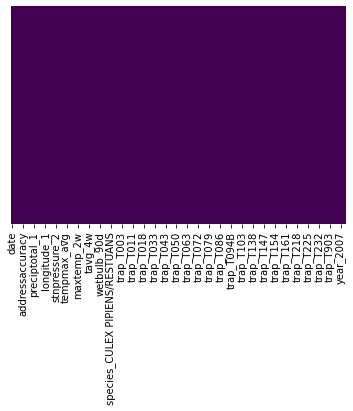

In [5]:
#double checking no null values in train visually and numerically - pure purple means 0 nulls

sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis');

print(f"number of null values: {train.isnull().sum().sum()}")

In [6]:
#checking for nulls in test
test.isnull().sum().sum()

0

In [7]:
#checking both column lengths
print(len(train.columns))
print(len(test.columns))

214
214


In [8]:
#the column lengths are identical but there shouldn't be "wnvpresent" in test. Dropping this:

test.drop(["wnvpresent"], axis=1, inplace=True)

In [9]:
train.shape
#we have a large file with 10,506 rows and 214 columns. 
#this means we can do carve out a validation set to help measure generalization

(10506, 214)

In [10]:
#all looks good now
test.head()

,date,address,block,street,addressnumberandstreet,latitude,longitude,addressaccuracy,tmax_1,tmin_1,...,month_5,month_6,month_7,month_8,month_9,month_10,year_2007,year_2009,year_2011,year_2013
0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,...,0,0,0,0,0,0,0,0,0,0


**We'll now compile all of the features that we *already* uncovered and explored in EDA to be meaningful in predicting WNV.**

## Feature Selection: Species

In [11]:
#From EDA, top mosquito species that are carriers of WNV are appended to a master feature list

key_species = [col for col in train if "PIPIENS" in col or "RESTUANS" in col]

key_species

['species_CULEX PIPIENS',
 'species_CULEX PIPIENS/RESTUANS',
 'species_CULEX RESTUANS']

## Feature Selection: Month

In [12]:
#our EDA showed no WNV in May - but the virus was present in June, July, Aug, Sep and Oct
#so we append that to our feature list

key_periods = [col for col in train if "month" in col]

key_periods.pop(0) #dropping May because the virus wasn't present

key_periods

['month_6', 'month_7', 'month_8', 'month_9', 'month_10']

## Feature Selection: Weather Features

In [13]:
#our earlier EDA found that there was a positive correlation between average temperature 
#as well as wet bulb average temperature.
#there were also skewed distributions/highly variable distributions 
#with station pressure average.
#there did not appear to be much relationship between WNV and precipitation, though, so omitting.

#we add this to our rolling list:

key_weather = ["temp_avg", "wetbulb_avg", "dewpoint_avg", 
               "stnpressure_avg", "relative_humidity"]

## Feature Selection: Traps

In [14]:
traps = [col for col in train if "trap" in col]

len(traps)

136

In [15]:
#let's see the top virulent traps


top_wnv_traps = train[traps][train["wnvpresent"]==1].sum().sort_values(ascending=False).head(36)

fig = px.bar(top_wnv_traps, orientation='v', 
             title = "Top Traps that are WNV Positive", 
             labels={"index":"trap number"})
fig.show()

#our cut off point for the top traps is till top 36 only because WNV traps decline sharply after

We choose traps rather than longitude/latitude to determine from a classification problem standpoint where WNV woud be present, because the traps correspond to specific geographical points already that are classified as single distinct categorical variables, some of which are particularly virulent.

We'll extract the top virulent traps as part of our features.

In [16]:
#re-extract top traps as a list

trap_temp = pd.DataFrame(top_wnv_traps).T

key_traps = [col for col in trap_temp.columns if "trap" in col]

### Feature Selection: Addresses

In [17]:
# our EDA showed that many addresses were badly hit. Let's dummify all the addresses for features
# so that our model can pick the most correlated and badly hit addresses

In [18]:
dummied_train = pd.get_dummies(train, drop_first=True)

In [19]:
dummied_test = pd.get_dummies(test, drop_first=True)

In [20]:
addresses = [col for col in dummied_train if "addressnumberandstreet" in col]

In [21]:
#let's remind ourselves the worst hit addresses in a visualization with 2 or more WNV cases

top_wnv_addresses = dummied_train[addresses][dummied_train["wnvpresent"]==1].sum().sort_values(ascending=False).head(76)

fig = px.bar(top_wnv_addresses, orientation='v', 
             title = "Top Addresses that are WNV Positive")
fig.show()

In [22]:
top_wnv_addresses

addressnumberandstreet_1000  W OHARE AIRPORT, Chicago, IL       66
addressnumberandstreet_1200  S DOTY AVE, Chicago, IL            41
addressnumberandstreet_4100  N OAK PARK AVE, Chicago, IL        18
addressnumberandstreet_1000  S STONY ISLAND AVE, Chicago, IL    16
addressnumberandstreet_4600  N MILWAUKEE AVE, Chicago, IL       14
                                                                ..
addressnumberandstreet_7900  S CHICAGO AVE, Chicago, IL          2
addressnumberandstreet_7700  S EBERHART AVE, Chicago, IL         2
addressnumberandstreet_2100  N LAWLER AVE, Chicago, IL           2
addressnumberandstreet_5100  W 72ND ST, Chicago, IL              2
addressnumberandstreet_6000  W ROSCOE ST, Chicago, IL            2
Length: 76, dtype: int64

In [23]:
address_temp = pd.DataFrame(top_wnv_addresses).T

key_addresses = [col for col in address_temp.columns if "address" in col]

len(key_addresses)

76

### Consolidating all Features

In [24]:
#combine all our chosen features into one

features = key_species + key_periods + key_weather + key_traps + key_addresses

features

['species_CULEX PIPIENS',
 'species_CULEX PIPIENS/RESTUANS',
 'species_CULEX RESTUANS',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'temp_avg',
 'wetbulb_avg',
 'dewpoint_avg',
 'stnpressure_avg',
 'relative_humidity',
 'trap_T900',
 'trap_T115',
 'trap_T002',
 'trap_T138',
 'trap_T003',
 'trap_T011',
 'trap_T128',
 'trap_T225',
 'trap_T013',
 'trap_T903',
 'trap_T008',
 'trap_T028',
 'trap_T009',
 'trap_T223',
 'trap_T114',
 'trap_T221',
 'trap_T086',
 'trap_T082',
 'trap_T061',
 'trap_T030',
 'trap_T135',
 'trap_T027',
 'trap_T016',
 'trap_T235',
 'trap_T233',
 'trap_T090',
 'trap_T230',
 'trap_T143',
 'trap_T103',
 'trap_T096',
 'trap_T151',
 'trap_T228',
 'trap_T155',
 'trap_T158',
 'trap_T066',
 'trap_T054',
 'addressnumberandstreet_1000  W OHARE AIRPORT, Chicago, IL',
 'addressnumberandstreet_1200  S DOTY AVE, Chicago, IL',
 'addressnumberandstreet_4100  N OAK PARK AVE, Chicago, IL',
 'addressnumberandstreet_1000  S STONY ISLAND AVE, Chicago, IL',
 'addressnumbe

In [25]:
X = dummied_train[features]
y = dummied_train["wnvpresent"]

## Baseline Score: ROC AUC of 0.5

Let's calculate what the baseline is:

In [26]:
dummied_train['wnvpresent'].value_counts()

0    9955
1     551
Name: wnvpresent, dtype: int64

If we take the baseline score as the majority class at `0.947554` accuracy, it's quite a tough benchmark to score better against thanks to the skewed distribution of our target columns.

However, because this is a binary classification model that has a severely imbalanced class (9955 negative in majority vs minority class at 551 observations), it makes more sense to compare the baseline against its ROC AUC. This baseline being a "no-skill classifier". This is one that cannot discriminate between the classes and would predict a random class or a constant class in all cases. A model with no skill is represented as with an **ROC AUC score of `0.5`, and thus is the baseline score**: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

* I will have to focus on tight feature selection to ensure our modelling has a chance to beat this high baseline.

* I'll also have to readjust scaling of weightage of majority vs minority class where possible in my models. 

For example, using XGBoost, it has a class weightage parameter called `scale_pos_weight`. I set this that weightage to 18, whcih is the factor resulting from dividing 9955 no wnv cases divided the mere 551 wnv present. 

That weight is a penalty that will give classification errors made by the model on the minority class (WNV positive class) 18 times more impactful, and in turn causing 18 times more corrections over errors made on the majority class, based on what I learnt here: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/.

## Train, Validation and Test Splits

Because we have a large dataset, we're creating a **validation set separate from train and test set**.  

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Modelling and Scoring Function

We write a gigantic function that will model 4 major training models for our classification problem as to whether an observation has WNV, and then compare that with the validation set. 

This function will return the classification metrics, the best paramaters, and even a dataframed confusion matrix - and we can also use this to evaluate our metrics against the validation set. 

The 4 models are:
1. K-Nearest Neighbors
2. Random Forest Classifier
3. Gradient Boosting Classifier
5. XGBoosting Classifier
5. Support Vector Machine Classifier

We'll use `RobustScaler()` to standardize our data's scaling (except when using Random Forest). This is because we saw a fair number of outliers in the distributions that were already explored in the EDA notebook. Robust Scaler is so named because it handles outliers better.

In [28]:
def grid_modeller_val_scorer(classifier): #takes arguments "knn", "rf", "gb", "xgb" "svc"
    
    #all 5 classifier models correspond respectively to these 5 instantiated models:
    clf_knn = KNeighborsClassifier()
    clf_rf  = RandomForestClassifier()
    clf_gb = GradientBoostingClassifier()
    clf_svc = svm.SVC(class_weight="balanced") #i did this to account for the uneven classes
    clf_xgb = XGBClassifier()
    
    if classifier == "knn":
        pipe_knn = Pipeline([('scaler', RobustScaler()), 
                             ('clf_knn', clf_knn),])
        
        param_grid_knn = {'clf_knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                      'clf_knn__p': [1, 2],
                      'clf_knn__leaf_size': [10, 20, 30, 40, 50]}

        gs = GridSearchCV(pipe_knn, param_grid_knn, cv=5, n_jobs=-1, verbose=1, 
                          scoring = "roc_auc") 
        gs.fit(X_train, y_train)
    
    elif classifier == "rf":
        
        #run grid search on Random Forest params:
        param_grid_rf  = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                           'min_samples_leaf': [1, 3, 5],
                           'max_features': ['sqrt', 'log2'], 
                           'class_weight':[{0: w} for w in [1, 2, 4, 6, 10]]}] 
                            #another class re-weighting attempt
    
        gs = GridSearchCV(clf_rf, param_grid_rf, cv=5, n_jobs=-1, verbose=1,
                         scoring = "roc_auc") 
        gs.fit(X_train, y_train)
                            
    elif classifier == "gb":
        #create Gradient Boosting pipeline:
        pipe_gb = Pipeline([('scaler', RobustScaler()),
                            ("clf_gb",clf_gb),
                           ])
        #run grid search on Gradient Boosting Params
        param_grid_gb = [{'clf_gb__max_depth': [2,3,4,5],
                         'clf_gb__n_estimators': [100, 125, 150, 200],
                         'clf_gb__learning_rate': [.08, .1, .12]}]
    
        gs = GridSearchCV(pipe_gb, param_grid_gb, cv=5, n_jobs=-1, verbose=1,
                         scoring = "roc_auc") 
        gs.fit(X_train, y_train)
    
    elif classifier == "xgb":
        #create Gradient Boosting pipeline:
        pipe_xgb = Pipeline([('scaler', RobustScaler()),
                            ("clf_xgb",clf_xgb),
                           ])
        #run grid search on Xtreme Gradient Boosting Params
        param_grid_xgb = [{'clf_xgb__max_depth': [2,3,4,5,6,7,8,9,10],
                         'clf_xgb__n_estimators': [100, 125, 150, 200, 250],
                         'clf_xgb__learning_rate': [.1, .01, .05],
                           'clf_xgb__scale_pos_weight':list(range(18,52,2))
                          }]
                        
        gs = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, n_jobs=-1, verbose=1,
                         scoring = "roc_auc") 
        gs.fit(X_train, y_train)
                            
    elif classifier == "svc":
        #create SVM pipeline for classification and scaling
        pipe_svm = Pipeline([('scaler', RobustScaler()),
                             ("clf_svc", clf_svc), 
                            ])
        #run grid search on SVC paramaters
        param_grid_svm = {"clf_svc__C":[1,10], "clf_svc__gamma":[0.001, 0.01, 0.1, 1], 
                          "clf_svc__kernel":('linear', 'rbf','sigmoid','poly')}  
        
        gs = GridSearchCV(pipe_svm, param_grid_svm, cv=5, n_jobs=-1, verbose=1,
                         scoring = "roc_auc") 
        gs.fit(X_train, y_train)
    
    #get scores
    train_score = gs.score(X_train, y_train)
    val_score = gs.score(X_val, y_val)
        
    #get confusion matrix and classification metrics
    y_pred = gs.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    cm_df = pd.DataFrame(cm, columns=["pred_WNV","pred_no_WNV"], index=["actual_WNV","actual_no_WNV"])
        
    #get ROC AUC and F1 Score
    auc = roc_auc_score(y_val, y_pred)
    f1_score = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    
    metrics_list= [train_score, val_score, gs.best_score_, auc, f1_score, precision, recall]

    
    #print out accuracy, estimator and parameters from GridSearchCV
    print(f'best train accuracy score = {train_score}')
    print(f'best validation accuracy score = {val_score}')
    print(f'best grid search score = {gs.best_score_}')
    print(f'ROC AUC score = {auc}')
    print(f'f1_score={f1_score}')
    print(f"Precision - ability not to label as positive a sample that is negative = {precision}")
    print(f"Sensitivity or Recall - ability to find all the positive samples = {recall}")
    print(f'best estimator = {gs.best_estimator_}')
    print(f'best parameters = {gs.best_params_}')
    print(f"metrics list for {classifier}:", metrics_list)

    #prints confusion matrix
    return cm_df  

### K-Nearest Neighbours

In [28]:
grid_modeller_val_scorer("knn")

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   29.3s finished


best train accuracy score = 0.9255639203943559
best validation accuracy score = 0.6674818540215909
best grid search score = 0.7017090099339462
ROC AUC score = 0.5074172838141556
f1_score=0.03389830508474577
Precision - ability not to label as positive a sample that is negative = 0.2222222222222222
Sensitivity or Recall - ability to find all the positive samples = 0.01834862385321101
best estimator = Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('clf_knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=10,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=9, p=2,
                                      weights='uniform'))],
         verbose=False)
best parameters = {'clf_knn__leaf_size': 10, 'clf_knn__n_neighbors': 9, 'cl

,pred_WNV,pred_no_WNV
actual_WNV,1985,7
actual_no_WNV,107,2


### Random Forests Classifier

In [29]:
grid_modeller_val_scorer("rf")

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  5.5min finished


best train accuracy score = 0.924033430657818
best validation accuracy score = 0.7976470100585829
best grid search score = 0.8352885316046939
ROC AUC score = 0.5
f1_score=0.0
Precision - ability not to label as positive a sample that is negative = 0.0
Sensitivity or Recall - ability to find all the positive samples = 0.0
best estimator = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1},
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
best parameters = {'class_weight': {0: 1}, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 500}


/Users/grahamlim/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



,pred_WNV,pred_no_WNV
actual_WNV,1992,0
actual_no_WNV,109,0


### Gradient Boosting Trees Classifier 

In [31]:
grid_modeller_val_scorer("gb")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.6min finished


best train accuracy score = 0.8822395594772323
best validation accuracy score = 0.7872337975756236
best grid search score = 0.8288136874716402
ROC AUC score = 0.5040851479311742
f1_score=0.01785714285714286
Precision - ability not to label as positive a sample that is negative = 0.3333333333333333
Sensitivity or Recall - ability to find all the positive samples = 0.009174311926605505
best estimator = Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('clf_gb',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.08, loss='deviance',
                                            max_depth=2, max_features=None,
                                            max_leaf_nodes=None,
                

,pred_WNV,pred_no_WNV
actual_WNV,1990,2
actual_no_WNV,108,1


### Extreme Gradient Boosting Trees Classifier ("XGB")

**Warning: this will take at least 2 hours and 15 minutes to run!!**

In [29]:
grid_modeller_val_scorer("xgb")

Fitting 5 folds for each of 2295 candidates, totalling 11475 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 95.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 109.7min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 135.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 189.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 225.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 257.2min
[Parallel(n_jobs=-1)]: Done 11234 tasks  

best train accuracy score = 0.890577046084186
best validation accuracy score = 0.7895780369183154
best grid search score = 0.8317461362266274
ROC AUC score = 0.7133142662392691
f1_score=0.19324796274738065
Precision - ability not to label as positive a sample that is negative = 0.11066666666666666
Sensitivity or Recall - ability to find all the positive samples = 0.7614678899082569
best estimator = Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('clf_xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.05,
                               max_de

,pred_WNV,pred_no_WNV
actual_WNV,1325,667
actual_no_WNV,26,83


### Support Vector Machines Classifier

In [30]:
grid_modeller_val_scorer("svc")

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/grahamlim/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  2.1min finished


best train accuracy score = 0.9261084700550652
best validation accuracy score = 0.7696566080837111
best grid search score = 0.8174863927354492
ROC AUC score = 0.6932707895803397
f1_score=0.2062780269058296
Precision - ability not to label as positive a sample that is negative = 0.12321428571428572
Sensitivity or Recall - ability to find all the positive samples = 0.6330275229357798
best estimator = Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('clf_svc',
                 SVC(C=1, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.1,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose

,pred_WNV,pred_no_WNV
actual_WNV,1501,491
actual_no_WNV,40,69


In [31]:
# printing train score, test score, test error and precision into a dataframe to evaluate

metrics_list= ["train_score", "val_score", "gs.best_score_", "auc", "f1_score", 
               "precision", "recall"]

knn = [0.9255639203943559, 0.6674818540215909, 
       0.7017090099339462, 0.5074172838141556, 
       0.03389830508474577, 0.2222222222222222, 0.01834862385321101]
    
rf = [0.924033430657818, 0.7976470100585829, 0.8352885316046939, 0.5, 0.0, 0.0, 0.0]

gb = [0.8822395594772323, 0.7872337975756236, 0.8288136874716402, 0.5040851479311742, 
      0.01785714285714286, 0.3333333333333333, 0.009174311926605505]

xgb = [0.890577046084186, 0.7895780369183154, 0.8317461362266274, 
       0.7133142662392691, 0.19324796274738065, 0.11066666666666666, 0.7614678899082569]

svc = [0.9261084700550652, 0.7696566080837111, 0.8174863927354492, 0.6932707895803397, 
       0.2062780269058296, 0.12321428571428572, 0.6330275229357798]

eval_data = [knn, rf, gb, xgb, svc]

column_names = metrics_list

index = ["K-Nearest Neighbours", "Random Forests", "Gradient Boosting", "XGB",
         "Support Vector Machine" ]

eval_df = pd.DataFrame(eval_data, columns=column_names, index=index)
    
eval_df = eval_df.round(decimals = 4)#rounding down decimal points
eval_df

,train_score,val_score,gs.best_score_,auc,f1_score,precision,recall
K-Nearest Neighbours,0.9256,0.6675,0.7017,0.5074,0.0339,0.2222,0.0183
Random Forests,0.9240,0.7976,0.8353,0.5000,0.0000,0.0000,0.0000
Gradient Boosting,0.8822,0.7872,0.8288,0.5041,0.0179,0.3333,0.0092
XGB,0.8906,0.7896,0.8317,0.7133,0.1932,0.1107,0.7615
Support Vector Machine,0.9261,0.7697,0.8175,0.6933,0.2063,0.1232,0.6330


### Modelling Evaluation 

Based on this table and our particular output reproduced above, we see the clear winner is XGB. It has the highest ROC AUC Score at `0.7133`, although SVC's AUC score is not too far away at `0.6933`. This handily beats the baseline dumb model score of `0.5`.

The best parameters are `learning_rate': 0.05`, `max_depth: 4`, `n_estimators': 125`, and **very very importantly, our class weight reassignment parameter:** `scale_pos_weight: 20`.

This implies that based on the `auc` score, it ought to generalize well since the validation set scored **above `0.71`; the closer to 1, the better the model is at delineating between whether the virus is present or not.** 

### Recombining Initial Train and Validation Sets

Now that we've selected the model with the best performance on the validation set, we're going to tetrain the model on the combined train + validation sets using our best hyperparameter combination. 

We will then estimate generalisation performance against another test split internally conducted on the full train set (not the Kaggle test.csv) . 

If the test error is similar to the validation error then we can conclude that it will most likely generalise well to unseen data.

In [32]:
#we're now going to retrain our model on the full training set 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Now we're going to fit the our chosen model onto the full train set using the best parameters discovered in our outputs earlier.

### Scaling Full Train and Test set on Robust Scaler

We already used this in our earlier grid search, but didn't apply it to the full train and test data. The point of this is to transform data on a relatively standardized scale, except inlike `StandardScaler()`, `RobustScaler()` does a good job of accounting for outliers.

In [33]:
#firstly, we run the Robust Scaler that worked out well in our GridSearch

rs = RobustScaler()
rs.fit(X_train)
X_train = rs.transform(X_train)
X_test = rs.transform(X_test)

In [34]:
#we also run this scaler too on our actual test set for Kaggle submission later

test_scaled = rs.fit_transform(dummied_test[features])

### Fitting and Predicting Our XGB Production Model on the Recombined Train Set 

In [35]:
#Instantiate and fit our XGB Model
xgb = XGBClassifier(learning_rate=0.05, max_depth=4, n_estimators = 125, scale_pos_weight = 20)

In [36]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=125, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=20, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
#checking out the cross-validation score. 
auc_cross_val_score = np.mean(cross_val_score(xgb, X_train, y_train, scoring="roc_auc"))
train_score = xgb.score(X_train, y_train)
test_score = xgb.score(X_test, y_test)

# make predictions for test data
y_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=["pred_WNV","pred_no_WNV"], index=["actual_WNV","actual_no_WNV"])
        
#get ROC AUC and F1 Score
auc = roc_auc_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
    
metrics_list= [train_score, test_score, auc_cross_val_score, auc, f1_score, precision, recall]

#print out accuracy, estimator and parameters from GridSearchCV
print(f'best train accuracy score = {train_score}')
print(f'best test accuracy score = {test_score}')
print(f'ROC AUC-scored cross validation score = {auc_cross_val_score}')
print(f'ROC AUC score = {auc}')
print(f'f1_score={f1_score}')
print(f"Precision - ability not to label as positive a sample that is negative = {precision}")
print(f"Sensitivity or Recall - ability to find all the positive samples = {recall}")
print(f"metrics list for xgb full train = {metrics_list}")

best train accuracy score = 0.6980009519276535
best test accuracy score = 0.7017126546146527
ROC AUC-scored cross validation score = 0.8102656611778707
ROC AUC score = 0.7395536692223439
f1_score=0.21526908635794742
Precision - ability not to label as positive a sample that is negative = 0.12481857764876633
Sensitivity or Recall - ability to find all the positive samples = 0.7818181818181819
metrics list for xgb full train = [0.6980009519276535, 0.7017126546146527, 0.8102656611778707, 0.7395536692223439, 0.21526908635794742, 0.12481857764876633, 0.7818181818181819]


Text(0.5, 0, 'False Positive Rate')

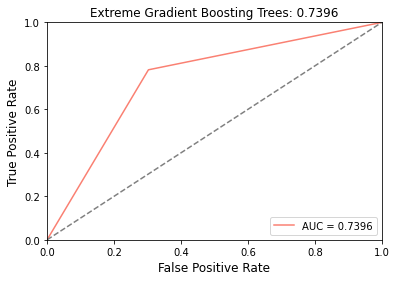

In [40]:

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

#plot ROC_AUC plot
plt.title(f"Extreme Gradient Boosting Trees: {round(roc_auc,4)}", size=12)
plt.plot(fpr, tpr, color='salmon', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='grey')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', size=12)
plt.xlabel('False Positive Rate', size=12)

## Evaluating Our XGB Production Model on the Recombined Train Set 

In [41]:
#building our final trained XGB Model metrics into a DataFrame
xgb_metrics_list= ["train_score", "test_score", 
                   "auc_cross_val_score", "auc", 
                   "f1_score", "precision", "recall"]
xgb_final = [0.6980009519276535, 0.7017126546146527, 
             0.8102656611778707, 0.7395536692223439, 
             0.21526908635794742, 0.12481857764876633, 0.7818181818181819]

xgb_final_df = pd.DataFrame(xgb_final).T

xgb_final_df.columns = xgb_metrics_list

xgb_final_df.rename(index = {0:"XGB Production Model on Recombined Train Set"}, inplace=True)

# Stack the DataFrames on top of each other
vertical_stack = pd.concat([eval_df, xgb_final_df], axis=0)

vertical_stack = vertical_stack.round(decimals = 4)

vertical_stack

,train_score,val_score,gs.best_score_,auc,f1_score,precision,recall,test_score,auc_cross_val_score
K-Nearest Neighbours,0.9256,0.6675,0.7017,0.5074,0.0339,0.2222,0.0183,NaN,NaN
Random Forests,0.9240,0.7976,0.8353,0.5000,0.0000,0.0000,0.0000,NaN,NaN
Gradient Boosting,0.8822,0.7872,0.8288,0.5041,0.0179,0.3333,0.0092,NaN,NaN
XGB,0.8906,0.7896,0.8317,0.7133,0.1932,0.1107,0.7615,NaN,NaN
Support Vector Machine,0.9261,0.7697,0.8175,0.6933,0.2063,0.1232,0.6330,NaN,NaN
XGB Production Model on Recombined Train Set,0.6980,NaN,NaN,0.7396,0.2153,0.1248,0.7818,0.7017,0.8103


### Explanation

Looking at all our metrics above in the combined table, after training our XGB model with its ideal parameters onto the entire train set, the `auc` score rises to `0.7396` from the initial validation AUC score to `0.7133`. We also ran a `auc_cross_val_score` on our production model, which shows a really high mean cross validation score of `0.8103`. 

**The fact that AUC score on the full recombined set has a a higher score than the validation set AUC score, as well as the high AUC Cross Validation Score, indicates that the model will generalize well on unseen data.** 

This means we are happy with our production model's generalized performance, especially since the ROC AUC score is still significantly higher than our dumb baseline of `0.5`.

Let's now also check out what the top features ranked by coefficient weightage in our production model are. 

In [47]:
#Visualizing top features in our production model. 
features=xgb.feature_importances_

key_features = pd.Series(features,index=X.columns)

sorted_features = key_features.sort_values(ascending=False).head(75)

fig = px.bar(sorted_features, orientation='v', 
             title = "Top Features to detect WNV", 
             labels={"index":"features"})
fig.show()

Text(0.5, 1.0, 'Top Features in Production Model')

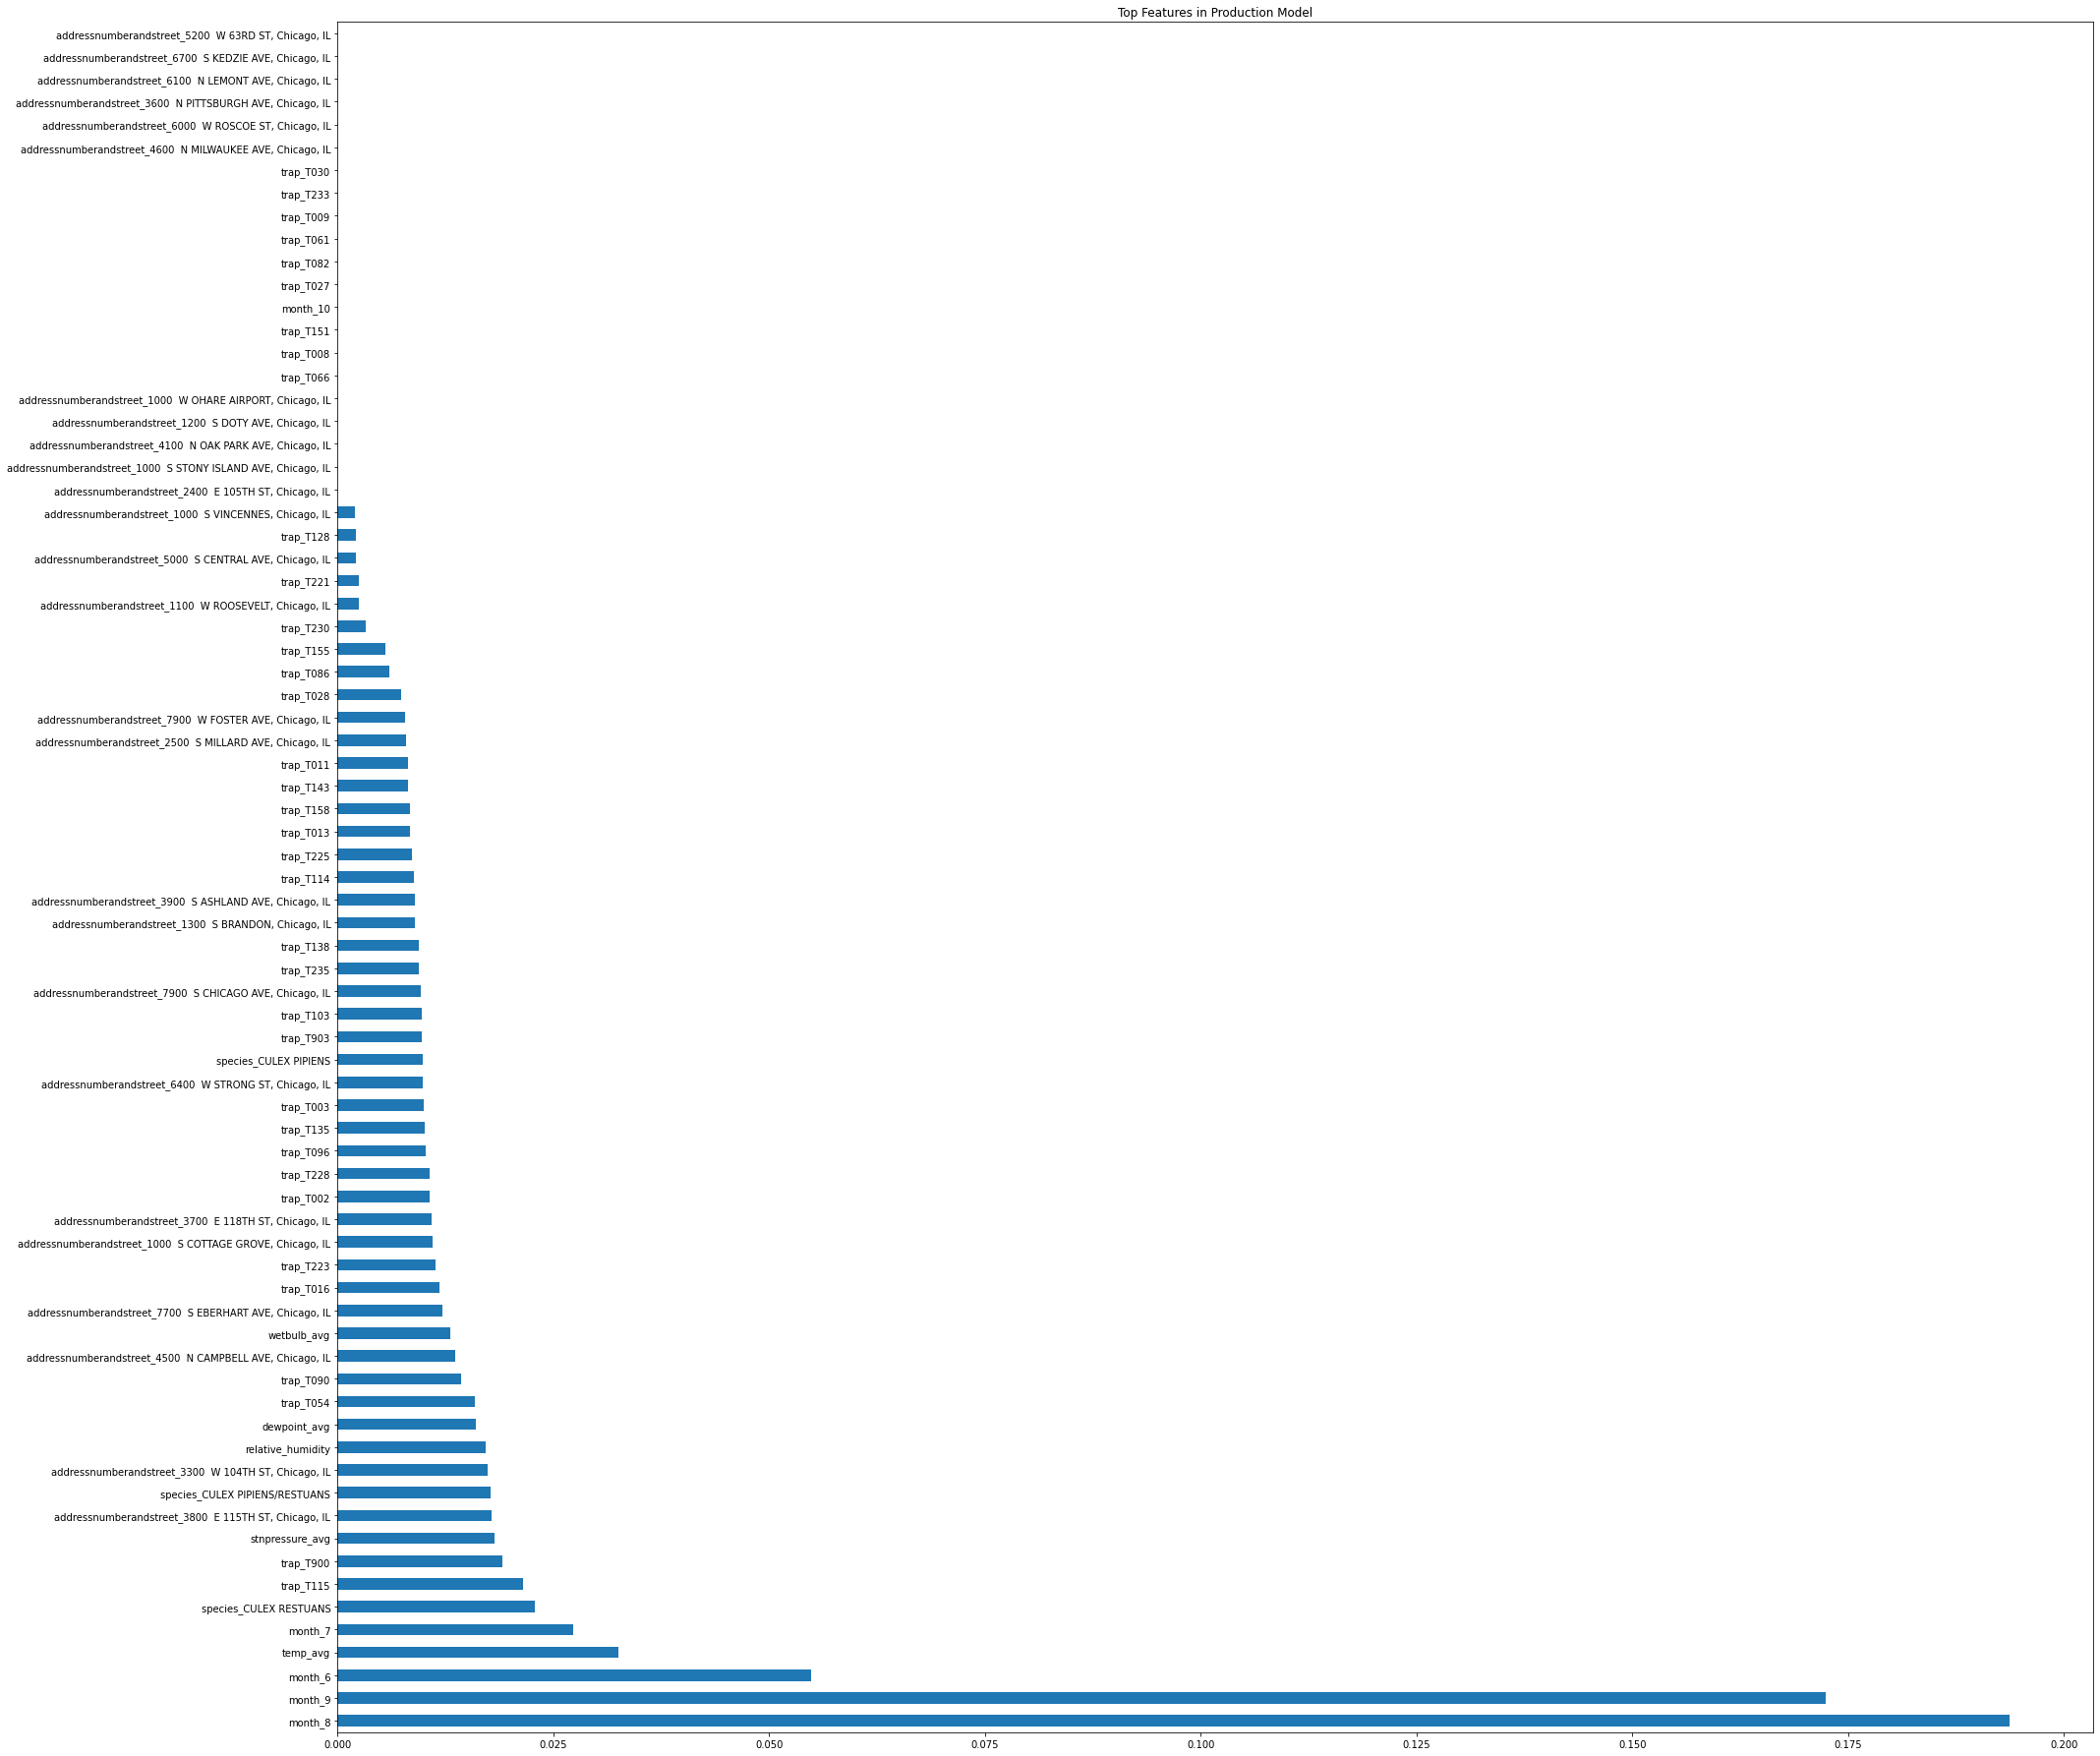

In [79]:
plt.figure(figsize=(32,32))
sorted_features.plot(kind='barh');
plt.title("Top Features in Production Model")

### Good Mosquito Breeding Conditions = Higher WNV Probability

### Certain Addresses and Traps are way more Virulent than Others

### The Culex Pipen and Restuans are the Worst Species

We see that the top features in our model relate to the virulent months like 
* August
* June
* July

These are the hottest months in Chicago: https://wgntv.com/weather/weather-blog/ask-tom-why/what-month-on-average-is-chicagos-hottest-month-i/#:~:text=In%20weather%20records%20dating%20from,average%20temperature%20of%2067.8%20degrees.

That seasonality is also why `Station Pressure` - or higher atmospheric pressure in the weather - also is a top feature; and `Relative Humidity` - with moister conditions encouraging mosquitoes and the virus.

In other words, the **weather really matters** in predicting the virus.

We also see certain addresses we saw in our older EDA are indeed top virus areas like `4500 N Campbell Ave, Chicago`, or `Trap T115`.

# Cost Benefit Analysis

### Kaggle Submission File

In [80]:
#we now submit this to Kaggle 
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=125, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=20, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
test_preds = xgb.predict(test_scaled)

In [82]:
samplesubmission = pd.read_csv('../assets/sampleSubmission.csv')

In [83]:
output = pd.DataFrame({'Id': samplesubmission.Id, 'WnvPresent': test_preds})
output.to_csv('../assets/submitted.csv', index=False)#outputting submitted.csv with Id index column complying with sample's format